# Chapter 15 – Processing Sequences Using RNNs and CNNs

This notebook contains all the sample code and solutions to the exercises in chapter 15.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/rnn``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Basic RNNs
Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the Chicago's Data Portal.

In [6]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'.\\datasets\\ridership.tgz'

In [7]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [8]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

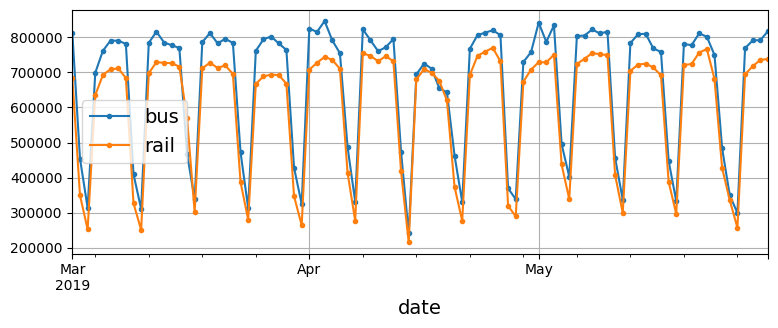

In [9]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

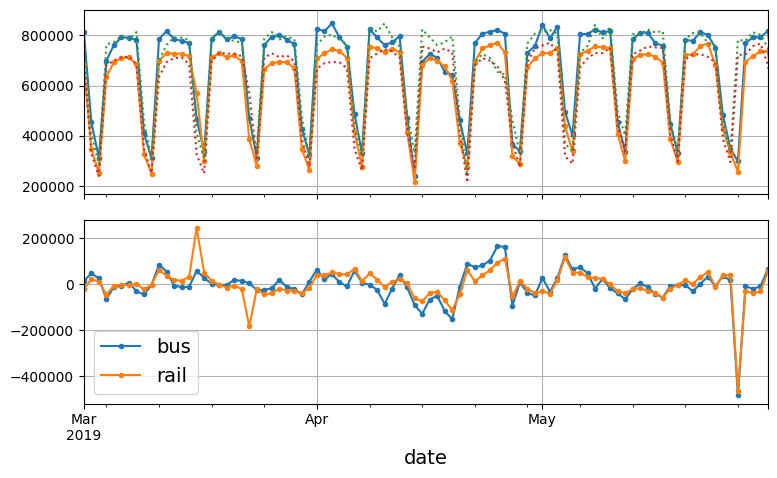

In [10]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [11]:

list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [12]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [13]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64


Now let's look at the yearly seasonality and the long-term trends:

C:\Users\schre\AppData\Local\Temp\ipykernel_24384\1463308178.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean(numeric_only=True)  # compute the mean for each month. use umeric_only=True for pandas>=2.0


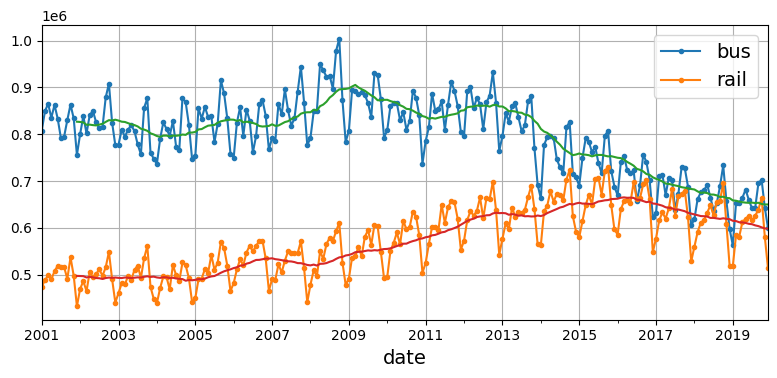

In [14]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean(numeric_only=True)  # compute the mean for each month. use umeric_only=True for pandas>=2.0
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

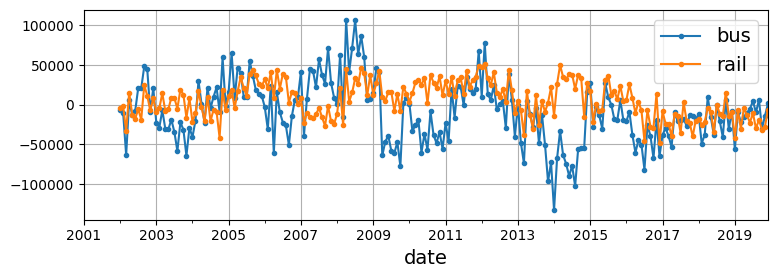

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

In [16]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [17]:
y_pred[0]  # ARIMA forecast

C:\Users\schre\AppData\Local\Temp\ipykernel_24384\3394422362.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


427758.62622130173

In [18]:

df["rail"].loc["2019-06-01"]  # target value

379044

In [19]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [20]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

C:\Users\schre\AppData\Local\Temp\ipykernel_24384\1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\schre\AppData\Local\Temp\ipykernel_24384\1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\schre\AppData\Local\Temp\ipykernel_24384\1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\User

In [21]:
mae

32040.72010083555

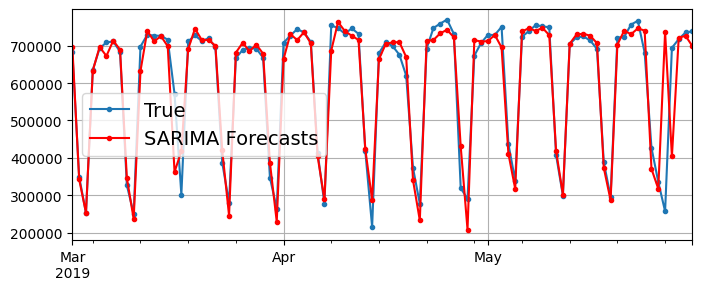

In [22]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

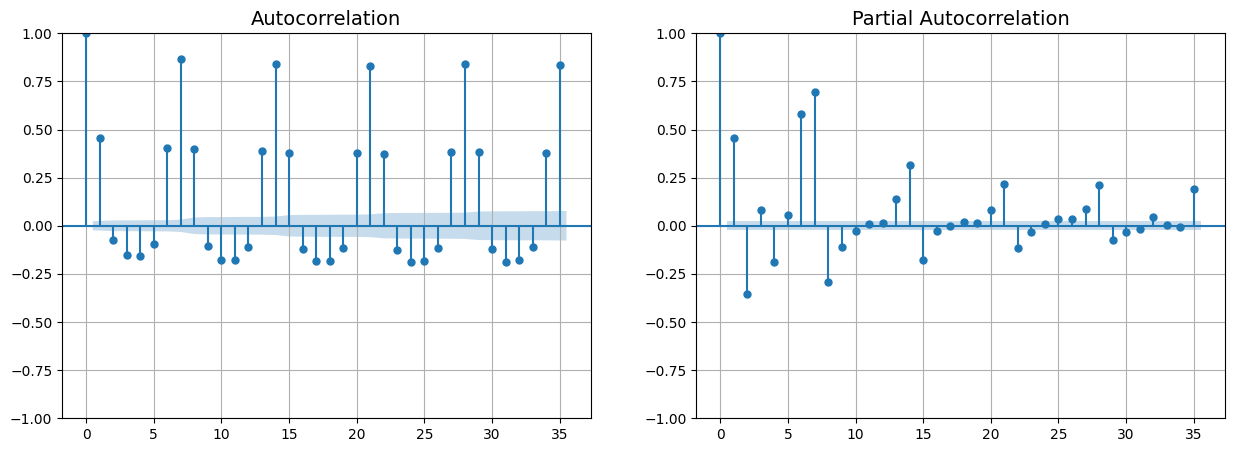

In [23]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()


In [24]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [25]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [26]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [27]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [28]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [29]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [30]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [31]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 5ms/step - loss: 0.0391 - mae: 0.2067 - val_loss: 0.0122 - val_mae: 0.1242
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - mae: 0.1355 - val_loss: 0.0104 - val_mae: 0.1166
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - mae: 0.1199 - val_loss: 0.0065 - val_mae: 0.0916
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0100 - mae: 0.1053 - val_loss: 0.0054 - val_mae: 0.0824
Epoch 5/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - mae: 0.0927 - val_loss: 0.0048 - val_mae: 0.0751
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - mae: 0.0877 - val_loss: 0.0045 - val_mae: 0.0715
Epoch 7/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - mae: 0.0836 - val_loss: 0.0036 - val_mae: 0.0631
Epoch 8/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - m

In [32]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0372


37164.751440286636

## Using a Simple RNN

In [33]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [34]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [35]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 23ms/step - loss: 0.5160 - mae: 0.8941 - val_loss: 0.8622 - val_mae: 1.3620
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.1604 - mae: 0.4086 - val_loss: 0.0659 - val_mae: 0.3156
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0492 - mae: 0.2502 - val_loss: 0.0387 - val_mae: 0.2064
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0253 - mae: 0.1653 - val_loss: 0.0211 - val_mae: 0.1537
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0211 - mae: 0.1722 - val_loss: 0.0206 - val_mae: 0.1496
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0204 - mae: 0.1662 - val_loss: 0.0201 - val_mae: 0.1462
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0199 - mae: 0.1657 - val_loss: 0.0196 - val_mae: 0.1434
Epoch 8/500
33/33 [==============================] - 1s 18ms/step - loss: 0.

102856.00274801254

In [36]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [37]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0454 - mae: 0.2051 - val_loss: 0.0033 - val_mae: 0.0629
Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0045 - mae: 0.0638 - val_loss: 0.0022 - val_mae: 0.0358
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0042 - mae: 0.0627 - val_loss: 0.0035 - val_mae: 0.0604
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0037 - mae: 0.0546 - val_loss: 0.0021 - val_mae: 0.0343
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0022 - val_mae: 0.0373
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0033 - mae: 0.0518 - val_loss: 0.0023 - val_mae: 0.0359
Epoch 8/500
33/33 [==============================] - 1s 18ms/step - loss: 0.

30022.229999303818

## Deep RNNs

In [38]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [39]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 3s 74ms/step - loss: 0.0222 - mae: 0.1661 - val_loss: 0.0087 - val_mae: 0.1035
Epoch 2/500
33/33 [==============================] - 2s 69ms/step - loss: 0.0077 - mae: 0.0958 - val_loss: 0.0036 - val_mae: 0.0627
Epoch 3/500
33/33 [==============================] - 2s 69ms/step - loss: 0.0057 - mae: 0.0741 - val_loss: 0.0030 - val_mae: 0.0580
Epoch 4/500
33/33 [==============================] - 2s 69ms/step - loss: 0.0052 - mae: 0.0697 - val_loss: 0.0025 - val_mae: 0.0515
Epoch 5/500
33/33 [==============================] - 2s 68ms/step - loss: 0.0046 - mae: 0.0650 - val_loss: 0.0040 - val_mae: 0.0671
Epoch 6/500
33/33 [==============================] - 2s 69ms/step - loss: 0.0046 - mae: 0.0650 - val_loss: 0.0024 - val_mae: 0.0493
Epoch 7/500
33/33 [==============================] - 2s 69ms/step - loss: 0.0048 - mae: 0.0666 - val_loss: 0.0028 - val_mae: 0.0538
Epoch 8/500
33/33 [==============================] - 2s 68ms/step - loss: 0.

29422.933235764503

## Multivariate time series

In [40]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [41]:

mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [42]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

import numpy as np

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(dtype='float32'),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(dtype='float32'),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [44]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0150 - mae: 0.1338 - val_loss: 0.0046 - val_mae: 0.0887
Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0028 - mae: 0.0578 - val_loss: 0.0026 - val_mae: 0.0631
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0019 - mae: 0.0443 - val_loss: 9.5832e-04 - val_mae: 0.0342
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0016 - mae: 0.0399 - val_loss: 6.0343e-04 - val_mae: 0.0248
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0015 - mae: 0.0381 - val_loss: 9.9052e-04 - val_mae: 0.0349
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0014 - mae: 0.0368 - val_loss: 7.8935e-04 - val_mae: 0.0295
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0013 - mae: 0.0359 - val_loss: 6.5859e-04 - val_mae: 0.0249
Epoch 8/500
33/33 [==============================] - 1s 

23040.8925563097

In [45]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(dtype='float32'),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(dtype='float32'),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0638 - mae: 0.2485 - val_loss: 0.0049 - val_mae: 0.0797
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0047 - mae: 0.0698 - val_loss: 0.0021 - val_mae: 0.0498
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0030 - mae: 0.0530 - val_loss: 0.0011 - val_mae: 0.0341
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0026 - mae: 0.0503 - val_loss: 0.0025 - val_mae: 0.0584
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0025 - mae: 0.0498 - val_loss: 0.0013 - val_mae: 0.0375
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0024 - mae: 0.0480 - val_loss: 0.0012 - val_mae: 0.0369
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0023 - mae: 0.0474 - val_loss: 0.0011 - val_mae: 0.0342
Epoch 8/500
33/33 [==============================] - 1s 18ms/step - loss: 0.

24780.459702014923

In [46]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6


43441.63157894738

In [47]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 4ms/step
bus 26078
rail 23482


## Forecasting Several Steps Ahead

In [48]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 13ms/step


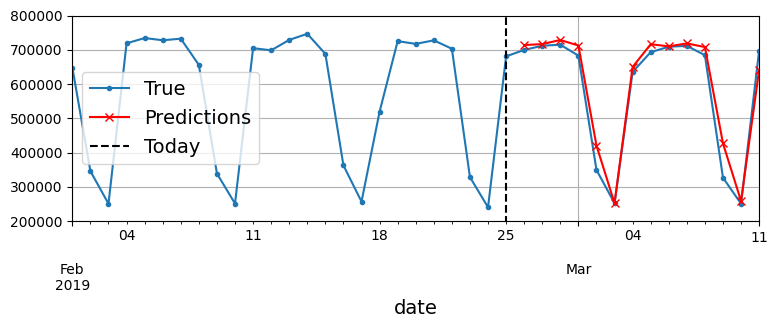

In [49]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [50]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(dtype='float32'),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(dtype='float32'),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [51]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [52]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0831 - mae: 0.3078 - val_loss: 0.0241 - val_mae: 0.1651
Epoch 2/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0181 - mae: 0.1528 - val_loss: 0.0150 - val_mae: 0.1330
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0135 - mae: 0.1315 - val_loss: 0.0118 - val_mae: 0.1181
Epoch 4/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0116 - mae: 0.1214 - val_loss: 0.0101 - val_mae: 0.1095
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0103 - mae: 0.1142 - val_loss: 0.0089 - val_mae: 0.1031
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0094 - mae: 0.1074 - val_loss: 0.0079 - val_mae: 0.0981
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0086 - mae: 0.1025 - val_loss: 0.0069 - val_mae: 0.0916
Epoch 8/500
33/33 [==============================] - 1s 18ms/step - loss: 0.

34336.61907911301

In [53]:
X = mulvar_valid.to_numpy(dtype='float32')[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 65ms/step


Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use ```to_windows()``` twice, to get sequences of consecutive windows, like this:

In [54]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

Then we can split these elements into the desired inputs and targets:

In [55]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [56]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [57]:
#fix: x = np.asarray(x).astype('float32').

seq2seq_train = to_seq2seq_dataset(mulvar_train.astype('float32'), shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid.astype('float32'))

In [58]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [59]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500


33/33 [==============================] - 2s 39ms/step - loss: 0.0527 - mae: 0.2329 - val_loss: 0.0137 - val_mae: 0.1232
Epoch 2/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0092 - mae: 0.0990 - val_loss: 0.0074 - val_mae: 0.0849
Epoch 3/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0068 - mae: 0.0820 - val_loss: 0.0061 - val_mae: 0.0752
Epoch 4/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0058 - mae: 0.0738 - val_loss: 0.0054 - val_mae: 0.0690
Epoch 5/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0052 - mae: 0.0680 - val_loss: 0.0049 - val_mae: 0.0636
Epoch 6/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0048 - mae: 0.0647 - val_loss: 0.0048 - val_mae: 0.0625
Epoch 7/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0046 - mae: 0.0624 - val_loss: 0.0045 - val_mae: 0.0593
Epoch 8/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0044 - mae: 

47631.409019231796

In [60]:
X = mulvar_valid.to_numpy(dtype='float32')[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 74ms/step


In [61]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 9ms/step
MAE for +1: 26,010
MAE for +2: 29,816
MAE for +3: 30,700
MAE for +4: 32,721
MAE for +5: 33,479
MAE for +6: 33,739
MAE for +7: 33,220
MAE for +8: 32,869
MAE for +9: 32,987
MAE for +10: 31,984
MAE for +11: 37,254
MAE for +12: 35,353
MAE for +13: 35,043
MAE for +14: 33,808


## Deep RNNs with Layer Norm

In [62]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [63]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [64]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 71ms/step - loss: 0.0558 - mae: 0.2398 - val_loss: 0.0180 - val_mae: 0.1386
Epoch 2/5
33/33 [==============================] - 2s 67ms/step - loss: 0.0131 - mae: 0.1293 - val_loss: 0.0135 - val_mae: 0.1139
Epoch 3/5
33/33 [==============================] - 2s 67ms/step - loss: 0.0103 - mae: 0.1118 - val_loss: 0.0110 - val_mae: 0.1053
Epoch 4/5
33/33 [==============================] - 2s 63ms/step - loss: 0.0089 - mae: 0.1013 - val_loss: 0.0095 - val_mae: 0.0979
Epoch 5/5
3/3 [==============================] - 0s 20ms/step - loss: 0.0083 - mae: 0.0912


91222.48739004135

## Extra Material – Creating a Custom RNN Class

The RNN class is not magical. In fact, it's not too hard to implement your own RNN class:

In [65]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that ```@tf.function``` requires the ```outputs``` variable to be created before the for loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, ```@tf.function``` requires the ```sequences``` variable to be created before the if statement where it is used, even if ```self.return_sequences``` is False, so we create a ```TensorArray``` of size 0 in this case.

In [66]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])


Just training for 5 epochs to show that it works (you can increase this if you want):

In [67]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 76ms/step - loss: 0.0745 - mae: 0.2638 - val_loss: 0.0149 - val_mae: 0.1330
Epoch 2/5
33/33 [==============================] - 2s 69ms/step - loss: 0.0098 - mae: 0.1102 - val_loss: 0.0092 - val_mae: 0.1000
Epoch 3/5
33/33 [==============================] - 2s 68ms/step - loss: 0.0072 - mae: 0.0908 - val_loss: 0.0073 - val_mae: 0.0864
Epoch 4/5
33/33 [==============================] - 3s 75ms/step - loss: 0.0064 - mae: 0.0828 - val_loss: 0.0066 - val_mae: 0.0813
Epoch 5/5
3/3 [==============================] - 0s 18ms/step - loss: 0.0060 - mae: 0.0763


76250.03159046173

## LSTMs

In [68]:

tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [69]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 15ms/step - loss: 0.0517 - mae: 0.2422 - val_loss: 0.0179 - val_mae: 0.1631
Epoch 2/5
33/33 [==============================] - 0s 8ms/step - loss: 0.0169 - mae: 0.1565 - val_loss: 0.0174 - val_mae: 0.1459
Epoch 3/5
33/33 [==============================] - 0s 9ms/step - loss: 0.0157 - mae: 0.1515 - val_loss: 0.0167 - val_mae: 0.1416
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0150 - mae: 0.1470 - val_loss: 0.0160 - val_mae: 0.1396
Epoch 5/5
3/3 [==============================] - 0s 7ms/step - loss: 0.0154 - mae: 0.1357


135708.07874202728

## GRUs

In [70]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [71]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 1s 13ms/step - loss: 0.0542 - mae: 0.2563 - val_loss: 0.0179 - val_mae: 0.1531
Epoch 2/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0146 - mae: 0.1384 - val_loss: 0.0144 - val_mae: 0.1303
Epoch 3/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0124 - mae: 0.1274 - val_loss: 0.0132 - val_mae: 0.1251
Epoch 4/5
33/33 [==============================] - 0s 7ms/step - loss: 0.0115 - mae: 0.1224 - val_loss: 0.0124 - val_mae: 0.1217
Epoch 5/5
3/3 [==============================] - 0s 9ms/step - loss: 0.0120 - mae: 0.1189


118941.14315509796

## Using One-Dimensional Convolutional Layers to Process Sequences
```  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [72]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train.astype('float32'), seq_length=112,
                                       shuffle=True, seed=42, )
longer_valid = to_seq2seq_dataset(mulvar_valid.astype('float32'), seq_length=112)

#longer_train = longer_train.astype('float32')
#longer_valid = longer_valid.astype('float32')

#X=X.astype('float32')
#Y=Y.astype('float32')

downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

Just training for 5 epochs to show that it works (you can increase this if you want):

In [73]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 4s 15ms/step - loss: 0.0572 - mae: 0.2660 - val_loss: 0.0188 - val_mae: 0.1513
Epoch 2/5
31/31 [==============================] - 0s 13ms/step - loss: 0.0153 - mae: 0.1452 - val_loss: 0.0161 - val_mae: 0.1340
Epoch 3/5
31/31 [==============================] - 0s 8ms/step - loss: 0.0131 - mae: 0.1354 - val_loss: 0.0142 - val_mae: 0.1265
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 0.0116 - mae: 0.1259 - val_loss: 0.0126 - val_mae: 0.1184
Epoch 5/5
1/1 [==============================] - 0s 45ms/step - loss: 0.0111 - mae: 0.1105


110484.0561747551

## WaveNet

```

 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
 ```

In [74]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

Just training for 5 epochs to show that it works (you can increase this if you want):

In [75]:

fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 1s 16ms/step - loss: 0.0639 - mae: 0.2836 - val_loss: 0.0205 - val_mae: 0.1599
Epoch 2/5
31/31 [==============================] - 0s 7ms/step - loss: 0.0167 - mae: 0.1567 - val_loss: 0.0183 - val_mae: 0.1547
Epoch 3/5
31/31 [==============================] - 0s 7ms/step - loss: 0.0161 - mae: 0.1562 - val_loss: 0.0182 - val_mae: 0.1539
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 0.0159 - mae: 0.1558 - val_loss: 0.0180 - val_mae: 0.1523
Epoch 5/5
1/1 [==============================] - 0s 38ms/step - loss: 0.0176 - mae: 0.1499


149867.2515153885

## Extra Material – Wavenet Implementation
Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [76]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [77]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [78]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [79]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 1s 12ms/step - loss: 0.0597 - mae: 0.2667 - val_loss: 0.0191 - val_mae: 0.1444
Epoch 2/5
31/31 [==============================] - 0s 6ms/step - loss: 0.0137 - mae: 0.1386 - val_loss: 0.0147 - val_mae: 0.1286
Epoch 3/5
31/31 [==============================] - 0s 6ms/step - loss: 0.0112 - mae: 0.1230 - val_loss: 0.0128 - val_mae: 0.1161
Epoch 4/5
31/31 [==============================] - 0s 7ms/step - loss: 0.0093 - mae: 0.1082 - val_loss: 0.0104 - val_mae: 0.1057
Epoch 5/5
1/1 [==============================] - 0s 38ms/step - loss: 0.0089 - mae: 0.0964


96384.1825723648

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions
## 1. to 8.

1. Here are a few RNN applications:
* For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
* For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of collaborative filtering for a recommender system)
* For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)

2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].

3. To build a deep sequence-to-sequence RNN using Keras, you must set ```return_sequences=True``` for all RNN layers. To build a sequence-to-vector RNN, you must set ```return_sequences=True``` for all RNN layers except for the top RNN layer, which must have ```return_sequences=False``` (or do not set this argument at all, since False is the default).

4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with ```return_sequences=True``` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set ```return_sequences=True``` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step t, the target should be a vector containing the values at time steps t + 1 to t + 7).

5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use LSTM or GRU layers (this also helps with the unstable gradients problem).

6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. See Figure 15–12.

7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step t, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.

8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

## 9. Tackling the SketchRNN Dataset
*Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.*

The dataset is not available in TFDS yet, the pull request is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [80]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 [==============================] - 92s 0us/step


In [81]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [82]:
train_files

['datasets\\training.tfrecord-00000-of-00010',
 'datasets\\training.tfrecord-00001-of-00010',
 'datasets\\training.tfrecord-00002-of-00010',
 'datasets\\training.tfrecord-00003-of-00010',
 'datasets\\training.tfrecord-00004-of-00010',
 'datasets\\training.tfrecord-00005-of-00010',
 'datasets\\training.tfrecord-00006-of-00010',
 'datasets\\training.tfrecord-00007-of-00010',
 'datasets\\training.tfrecord-00008-of-00010',
 'datasets\\training.tfrecord-00009-of-00010']

In [83]:
eval_files

['datasets\\eval.tfrecord-00000-of-00010',
 'datasets\\eval.tfrecord-00001-of-00010',
 'datasets\\eval.tfrecord-00002-of-00010',
 'datasets\\eval.tfrecord-00003-of-00010',
 'datasets\\eval.tfrecord-00004-of-00010',
 'datasets\\eval.tfrecord-00005-of-00010',
 'datasets\\eval.tfrecord-00006-of-00010',
 'datasets\\eval.tfrecord-00007-of-00010',
 'datasets\\eval.tfrecord-00008-of-00010',
 'datasets\\eval.tfrecord-00009-of-00010']

In [84]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [85]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [86]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [87]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [88]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [89]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [90]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

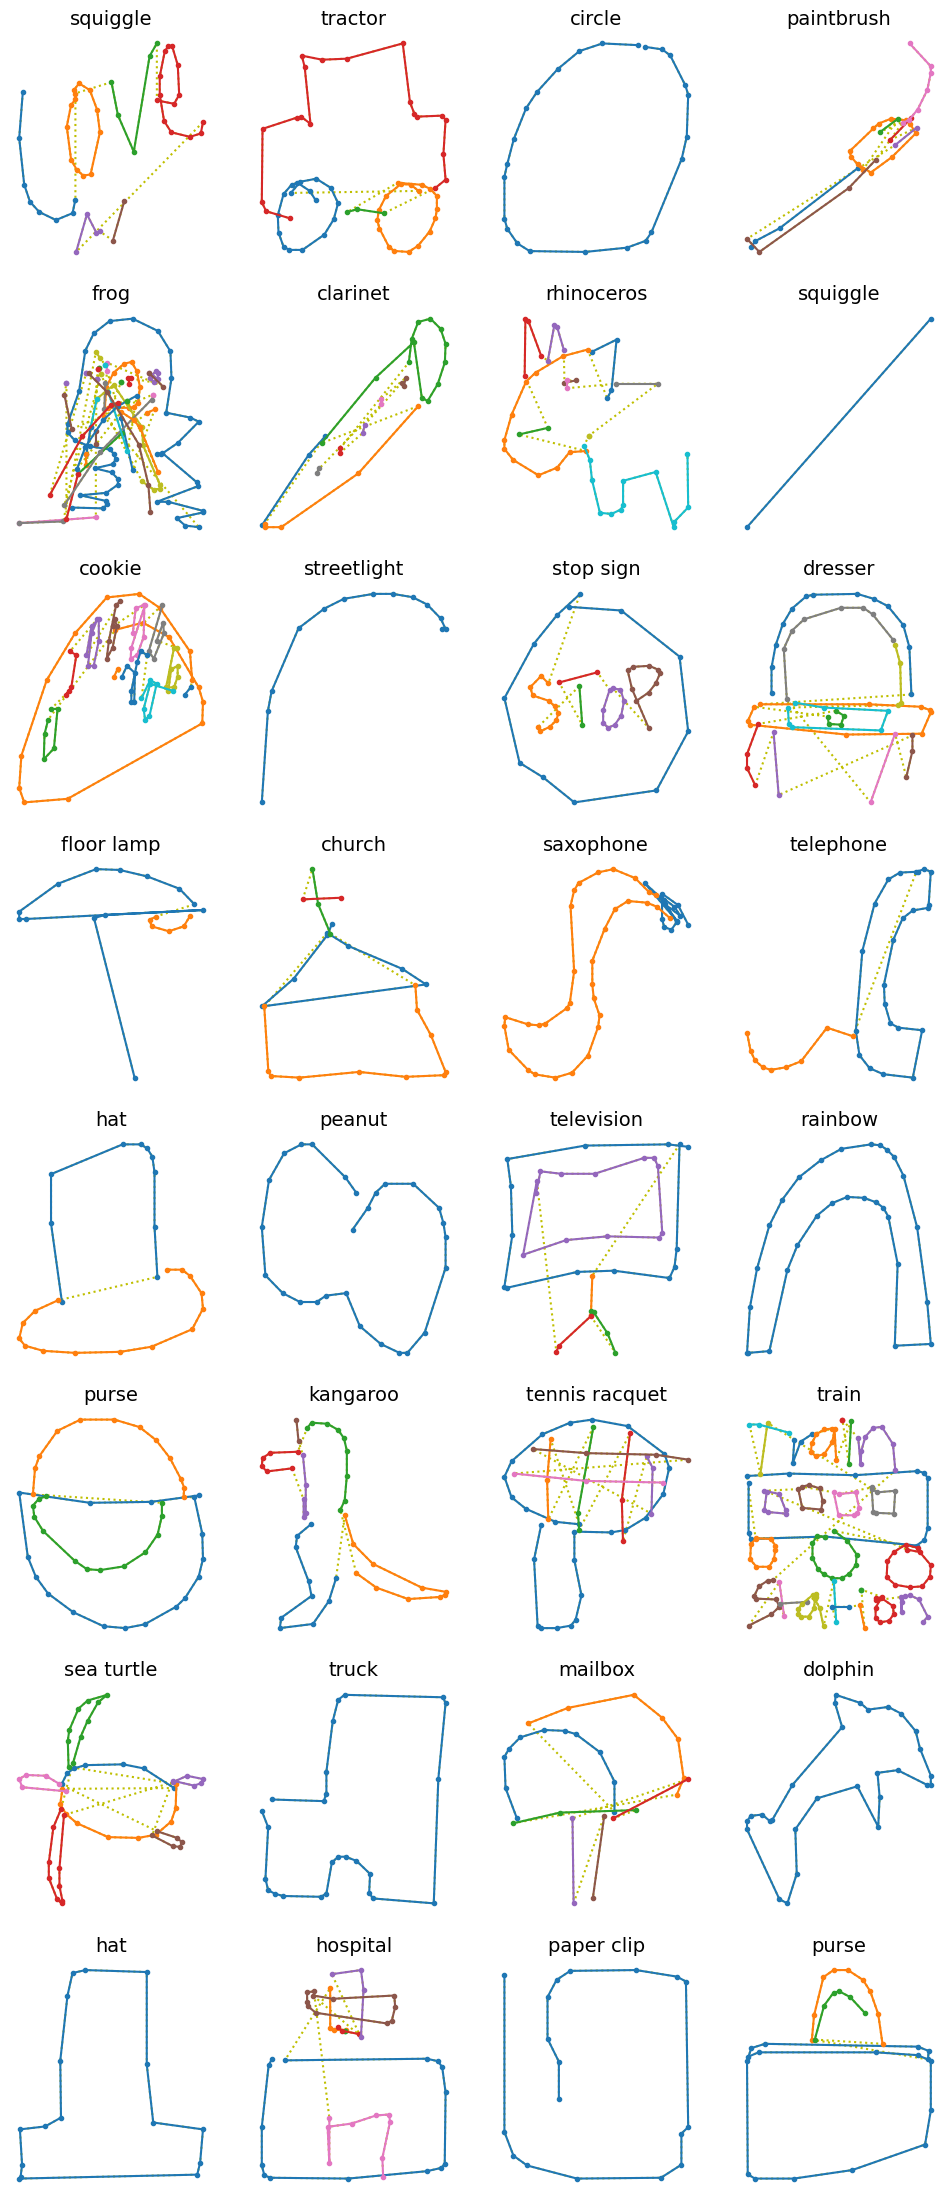

In [91]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

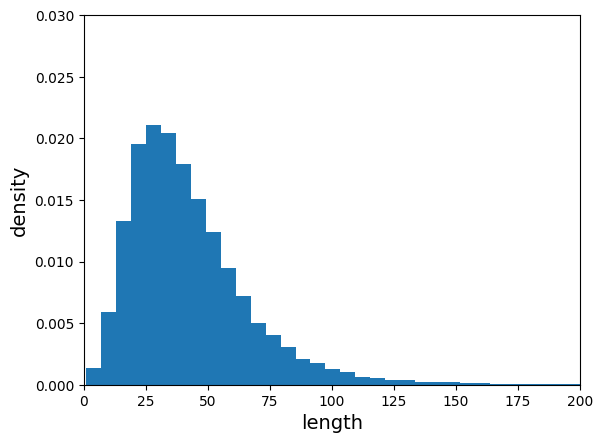

In [92]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [93]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 797s 7ms/step - loss: 4.1310 - accuracy: 0.1620 - sparse_top_k_categorical_accuracy: 0.3624 - val_loss: 3.0832 - val_accuracy: 0.3128 - val_sparse_top_k_categorical_accuracy: 0.5949
Epoch 2/2
107813/107813 [==============================] - 852s 8ms/step - loss: 2.7337 - accuracy: 0.3737 - sparse_top_k_categorical_accuracy: 0.6631 - val_loss: 2.5139 - val_accuracy: 0.4150 - val_sparse_top_k_categorical_accuracy: 0.7026


In [95]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 12s 2ms/step


In [96]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.5822243

1/1 [==============================] - 0s 299ms/step


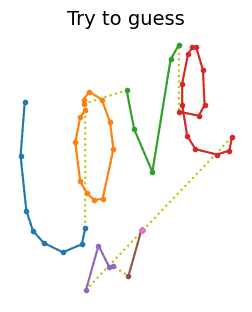

Top-5 predictions:
  1. animal migration 21.807%
  2. rain 20.668%
  3. stethoscope 8.919%
  4. smiley face 5.003%
  5. ant 4.971%
Answer: squiggle


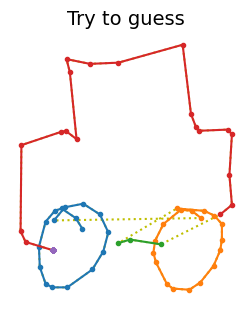

Top-5 predictions:
  1. headphones 26.970%
  2. car 14.057%
  3. police car 7.927%
  4. nose 5.857%
  5. tractor 3.928%
Answer: tractor


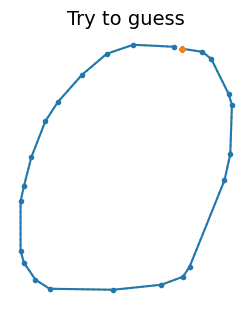

Top-5 predictions:
  1. circle 36.826%
  2. onion 11.754%
  3. watermelon 7.328%
  4. moon 5.694%
  5. pear 4.783%
Answer: circle


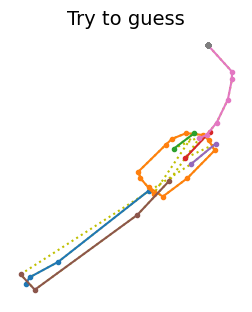

Top-5 predictions:
  1. matches 19.845%
  2. syringe 14.896%
  3. see saw 12.566%
  4. paintbrush 8.138%
  5. screwdriver 3.075%
Answer: paintbrush


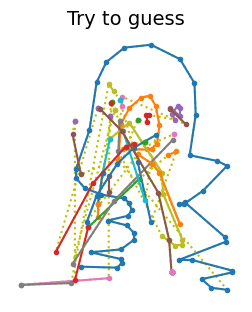

Top-5 predictions:
  1. spider 22.411%
  2. octopus 12.337%
  3. scorpion 4.262%
  4. ant 3.389%
  5. tiger 2.891%
Answer: frog


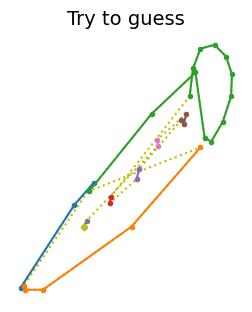

Top-5 predictions:
  1. syringe 27.201%
  2. see saw 25.598%
  3. rifle 4.264%
  4. beach 3.780%
  5. toothbrush 3.170%
Answer: clarinet


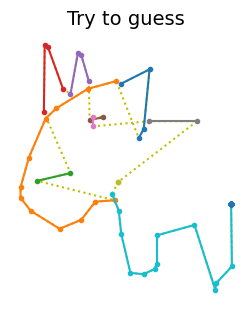

Top-5 predictions:
  1. animal migration 49.897%
  2. rhinoceros 13.336%
  3. cat 5.198%
  4. bird 3.216%
  5. mouse 2.835%
Answer: rhinoceros


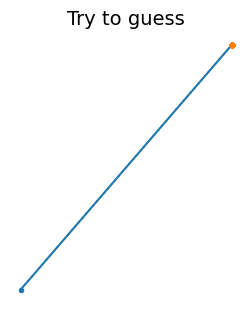

Top-5 predictions:
  1. line 29.493%
  2. tennis racquet 4.831%
  3. feather 4.543%
  4. lollipop 2.874%
  5. stitches 2.323%
Answer: squiggle


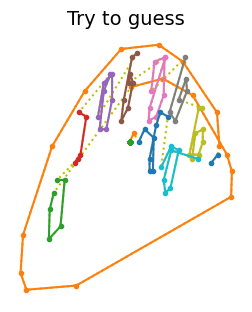

Top-5 predictions:
  1. stop sign 11.403%
  2. bracelet 10.452%
  3. blueberry 6.047%
  4. peas 5.140%
  5. skull 4.093%
Answer: cookie


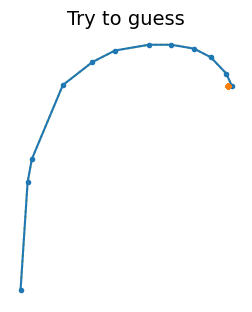

Top-5 predictions:
  1. animal migration 7.605%
  2. rainbow 6.443%
  3. stairs 6.174%
  4. rain 5.003%
  5. headphones 4.429%
Answer: streetlight


In [97]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [98]:
model.save("my_sketchrnn", save_format="tf")

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets


## 10. Bach Chorales
Exercise: Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out Google's Coconet model, which was used for a nice Google doodle about Bach.

In [99]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

117793/117793 [==============================] - 0s 0us/step


'.\\datasets\\jsb_chorales.tgz'

In [100]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [101]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [102]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57